# Environmental Monitoring & Pollution Control Project

## Week 1 – Dataset Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Bangalore_AQI_Dataset.csv')
df.head()

,City,Date,AQI,PM2.5,PM10,NO2,SO2,CO,O3
0,Bangalore,01-01-2018,68,37.4,73.44,56.44,77.52,0.71,64.6
1,Bangalore,02-01-2018,76,41.8,82.08,63.08,86.64,0.80,72.2
2,Bangalore,03-01-2018,70,38.5,75.60,58.10,79.80,0.74,66.5
3,Bangalore,04-01-2018,78,42.9,84.24,64.74,88.92,0.82,74.1
4,Bangalore,05-01-2018,82,45.1,88.56,68.06,93.48,0.86,77.9


### Problem Statement
Predict **Air Quality Index (AQI)** for Bangalore based on pollutant levels (`PM2.5`, `PM10`, `NO2`, `SO2`, `CO`, `O3`) and temporal features.

In [2]:
# Basic info & missing values
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   City    2556 non-null   object 
 1   Date    2556 non-null   object 
 2   AQI     2556 non-null   int64  
 3   PM2.5   2556 non-null   float64
 4   PM10    2543 non-null   float64
 5   NO2     2536 non-null   float64
 6   SO2     2537 non-null   float64
 7   CO      2550 non-null   float64
 8   O3      2546 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 179.8+ KB


City      0
Date      0
AQI       0
PM2.5     0
PM10     13
NO2      20
SO2      19
CO        6
O3       10
dtype: int64

In [3]:
# Parse Date and create features
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['dayofweek'] = df['Date'].dt.dayofweek

df.head()

,City,Date,AQI,PM2.5,PM10,NO2,SO2,CO,O3,year,month,day,dayofweek
0,Bangalore,2018-01-01,68,37.4,73.44,56.44,77.52,0.71,64.6,2018.0,1.0,1.0,0.0
1,Bangalore,2018-02-01,76,41.8,82.08,63.08,86.64,0.80,72.2,2018.0,2.0,1.0,3.0
2,Bangalore,2018-03-01,70,38.5,75.60,58.10,79.80,0.74,66.5,2018.0,3.0,1.0,3.0
3,Bangalore,2018-04-01,78,42.9,84.24,64.74,88.92,0.82,74.1,2018.0,4.0,1.0,6.0
4,Bangalore,2018-05-01,82,45.1,88.56,68.06,93.48,0.86,77.9,2018.0,5.0,1.0,1.0


### Exploratory Data Analysis (EDA)

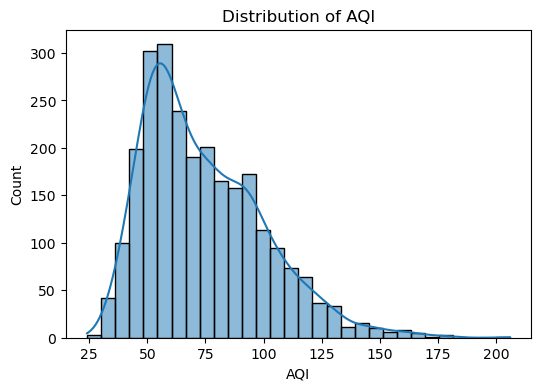

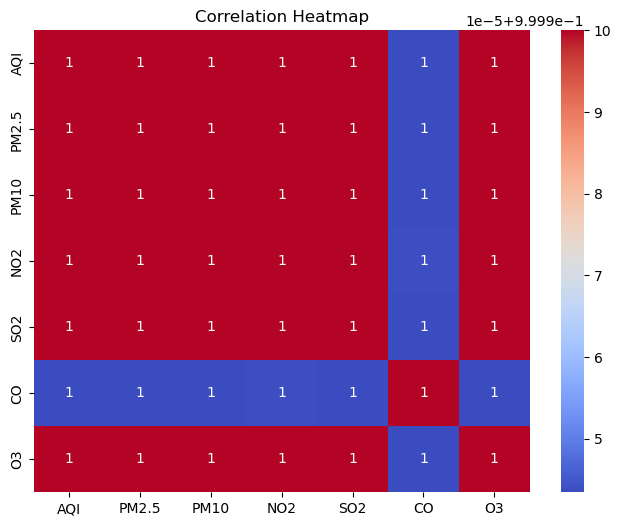

In [4]:
# Distribution of AQI
plt.figure(figsize=(6,4))
sns.histplot(df['AQI'], bins=30, kde=True)
plt.title('Distribution of AQI')
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[['AQI','PM2.5','PM10','NO2','SO2','CO','O3']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Week 2 – Model Development

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib
import numpy as np

# Features & Target (adjust feature list if your columns differ)
numeric_features = ['PM2.5','PM10','NO2','SO2','CO','O3','year','month','day','dayofweek']
cat_features = ['City']

X = df[numeric_features + cat_features]
y = df['AQI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), 
                                  ('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), 
                                  ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, cat_features)
])

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=200, random_state=42)
}

results = []
for name, model in models.items():
    pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    # Compat fix for RMSE: compute sqrt of MSE rather than use squared=False
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    results.append([name, r2, mae, rmse])

import pandas as pd
pd.DataFrame(results, columns=['Model','R2','MAE','RMSE'])

,Model,R2,MAE,RMSE
0,LinearRegression,1.000000,1.112999e-14,1.783006e-14
1,RandomForest,0.999952,2.439453e-02,1.733848e-01
2,GradientBoosting,0.999986,3.626375e-02,9.331535e-02


## 📊 Additional Visualizations

In [ ]:
# AQI over time
plt.figure(figsize=(12,5))
sns.lineplot(data=df, x='Date', y='AQI', hue='City')
plt.title('AQI Trends Over Time')
plt.ylabel('AQI')
plt.xlabel('Date')
plt.legend(title='City')
plt.show()

# Pollutants over time
pollutants = ['PM2.5','PM10','NO2','SO2','CO','O3']
plt.figure(figsize=(14,8))
for p in pollutants:
    sns.lineplot(data=df, x='Date', y=p, label=p)
plt.title('Pollutant Trends Over Time')
plt.ylabel('Concentration')
plt.xlabel('Date')
plt.legend()
plt.show()

In [ ]:
# City-wise AQI distribution
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='City', y='AQI')
plt.title('City-wise AQI Distribution')
plt.show()

# Month-wise AQI distribution
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='month', y='AQI')
plt.title('Month-wise AQI Distribution')
plt.xlabel('Month')
plt.show()

In [ ]:
# Pairplot of AQI and pollutants
sns.pairplot(df[['AQI','PM2.5','PM10','NO2','SO2','CO','O3']], diag_kind='kde')
plt.suptitle('Pairwise Relationships between AQI and Pollutants', y=1.02)
plt.show()

In [ ]:
# Scatter plots with regression lines
plt.figure(figsize=(6,5))
sns.regplot(data=df, x='PM2.5', y='AQI', scatter_kws={'alpha':0.3})
plt.title('AQI vs PM2.5')
plt.show()

plt.figure(figsize=(6,5))
sns.regplot(data=df, x='PM10', y='AQI', scatter_kws={'alpha':0.3})
plt.title('AQI vs PM10')
plt.show()

In [ ]:
# Monthly average AQI heatmap
monthly_avg = df.groupby(['year','month'])['AQI'].mean().reset_index()
pivot_table = monthly_avg.pivot(index='year', columns='month', values='AQI')

plt.figure(figsize=(10,6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap='YlOrRd')
plt.title('Monthly Average AQI Heatmap')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()